# Lab2: Data analysis

Throughout all the following labs, we will work on the following problem: 

**could AI have predicted who died and who survived the Titanic disaster ?**

We will begin by analyzing it using `pandas` and plot the data using `matplotlib` and `seaborn`.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

## Load dataset
The dataset is available in its `csv` format.

In [2]:
df = pd.read_csv("../titanic.csv")
df.shape

(891, 12)

In [3]:
pd.unique(df.Cabin).shape

(148,)

## Identify rows and columns
1. Find the number of rows and the number of columns

In [4]:
print(f"Number of individuals: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of individuals: 891
Number of columns: 12


2. List every column name and give a brief description of the data

**PassengerId**: Id of the passenger

**Survived**: Whether or not they survived the accident

**Pclass**: Passenger class

**Name**: Name of the passenger

**Sex**: Sex of the passenger

**Age**: Age of the passenger

**SibSp**: Number of siblings and spouses aboards

**Parch**: Number of parent and children aboards

**Ticket**: The ID of the ticket

**Fare**: The price of the ticket

**Cabin**: The name of the cabin

**Embarked**: From where the passenger has embarked

3. Specify for each column the data type and create a list `quantitative_vars` that will contain the names of the quantitative variables and `qualitative_vars` that will contain the names of the qualitative variables.

In [5]:
quantitative_vars = ["Age", "SibSp", "Parch", "Fare"]
qualitative_vars = ["PassengerId", "Ticket", "Name", "Embarked", "Cabin", "Sex", "Pclass", "Survived"]

**3. bonus question seen in class** Create new variables that seem relevant for the analysis.

We can create the following variables from the existing variables that seem relevant to the study:
- `lastname`: The lastname, by parsing the full name of the individual, may reflect individuals from the same family

- `nbr_fam_members`: The number of family members on the titanic. This combines the information within siblings/spouses and parent children and may be indicative of whether being together as a family has helped survival.

- `with_family`: This binary variable indicates whether or not the individual was there with their family (either children, siblings or spouse) and transforms the `nbr_fam_members` quantitative variable into a quality variable, which might be sufficient information for prediction.

- `age_category`: This variable transforms into a qualitative variable with three categories the age variable, which may improve prediction and analysis of the impact of age on the survival rate.

- `deck`: By parsing the first value of the Cabin number, we can see on which deck the individual is located.

- `nbr_cabin`: This variable gives the number of individuals in the cabin. Being together in the same cabin could affect the survival rate because people would be most likely to help each other.

- `cabin_shared`: This variable is the binary transformation of `nbr_cabin` and it indicates if the cabin was shared or not.

In [6]:
# Lastname of the person
df["lastname"] = df.Name.apply(lambda x: x.split(",")[0])

# Number of family members
df["nbr_fam_members"] = df.SibSp + df.Parch

# Is there with family ?
df["with_family"] = df.nbr_fam_members.apply(lambda x: "yes" if x>0 else "no")

# Age category
# Create function to use as lambda function to cut into categories
def age_category(age):
    if age <= 21:
        return "minor"
    elif age <= 50:
        return "adult"
    else:
        return "senior"
    
df["age_category"] = df.Age.apply(lambda x: age_category(x))


# What deck is the cabin located ?
df["deck"] = df.Cabin.apply(lambda x: x[0] if not pd.isnull(x) else np.nan)

# Number of person in the cabin
cabin_count = df.Cabin.value_counts()
df["nbr_cabin"] = df.merge(cabin_count, left_on="Cabin", right_index=True, how="outer")["Cabin_y"]

# Whether or not the cabin was shared
def cabin_shared(nbr_cabin):
    if not pd.isnull(nbr_cabin):
        if nbr_cabin > 1:
            return "shared"
        else:
            return "not_shared"
    else:
        return "n/a"
    
df["cabin_shared"] = df.nbr_cabin.apply(lambda x: cabin_shared(x))

In [7]:
# Additional variable treatment: p-class should be converted to a category as a string instead of being understood as an integer
df.Pclass = df.Pclass.astype(str)

4. What column are we trying to predict ? Store it into a list `target`.

**Answer**: *We are trying to predict whether or not individuals would survive the Titanic accident. This information is stored in the variable `Survived` of the dataset. It is a binary variable and we will use binary classification algorithms to solve this problem.*

In [8]:
target = ["Survived"]

5. Infer what columns will be used for prediction and what column you can omit immediately. Create the corresponding list `features` and update `quantitative_vars` and `qualitative_vars`.

**Answer**: *Name can be omitted, even as lastname because it has little information. Ticket is complicated to exploit and would require a thorough data processing (see https://www.kaggle.com/c/titanic/discussion/11127) which would take too long compared to this lab length. Cabin can also be dropped because it has many different values*. Other features and additional created features are kept for further analysis.

In [9]:
quantitative_vars = ["Age", "Parch", "SibSp", "Fare", "nbr_cabin", "nbr_fam_members"] 
qualitative_vars = ["Embarked", "deck", "with_family", "Sex", "Pclass", "age_category", "cabin_shared"]
features = quantitative_vars + qualitative_vars

6. Give the repartition of the target to predict using the `value_counts` method. How many people died in the Titanic disaster ? How many survived ?

**Answer**: *549 people died, 342 survived*.

In [10]:
df[target].value_counts()

Survived
0           549
1           342
dtype: int64

## Univariate analysis

1. For each **quantitative variables** (that you should have stored in the variable `quantitative_vars`), give the main statistical estimators: mean, median, standard error.



In [11]:
df[quantitative_vars].describe()

,Age,Parch,SibSp,Fare,nbr_cabin,nbr_fam_members
count,714.000000,891.000000,891.000000,891.000000,204.000000,891.000000
mean,29.699118,0.381594,0.523008,32.204208,1.696078,0.904602
std,14.526497,0.806057,1.102743,49.693429,0.845611,1.613459
min,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400,1.000000,0.000000
50%,28.000000,0.000000,0.000000,14.454200,2.000000,0.000000
75%,38.000000,0.000000,1.000000,31.000000,2.000000,1.000000
max,80.000000,6.000000,8.000000,512.329200,4.000000,10.000000


2. For each **quantitative variables** (that you should have stored in the variable `quantitative_vars`), plot the variable repartitions using `sns.histplot` and `sns.violinplot`. Deduce for each variable a possible distribution.

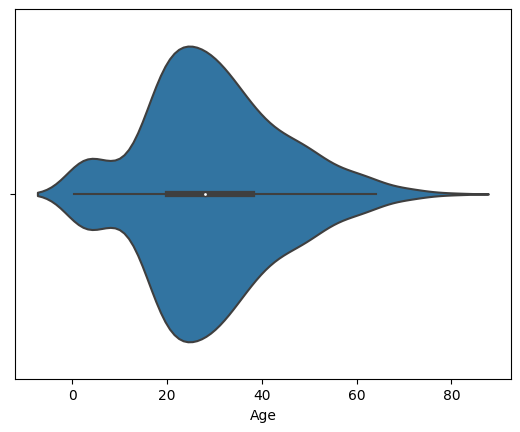

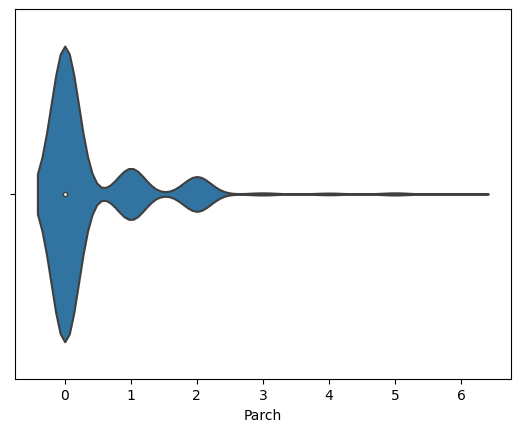

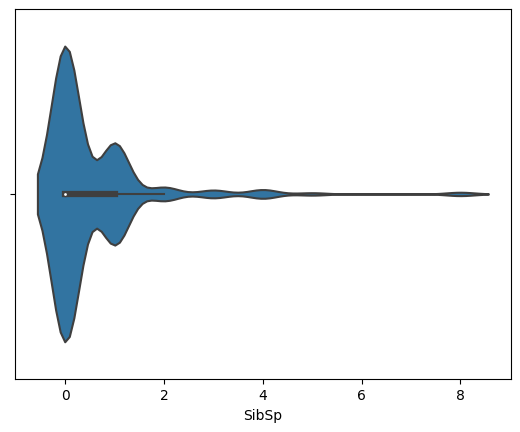

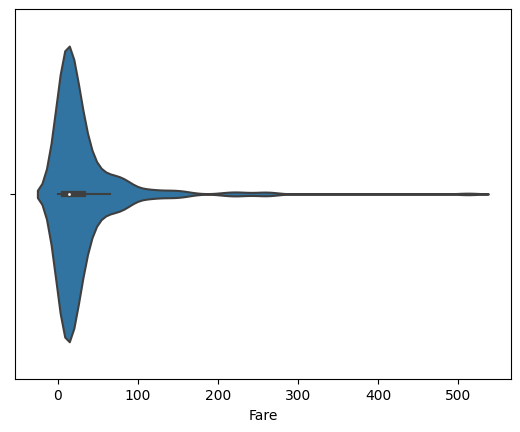

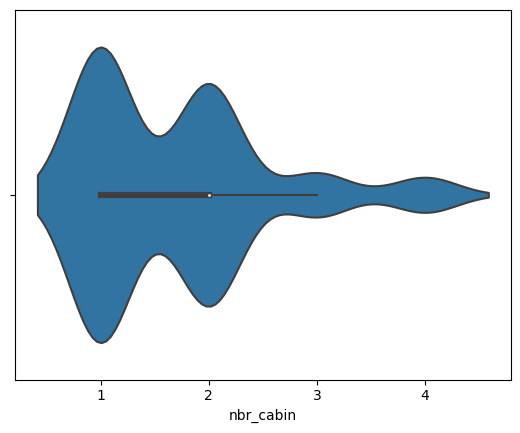

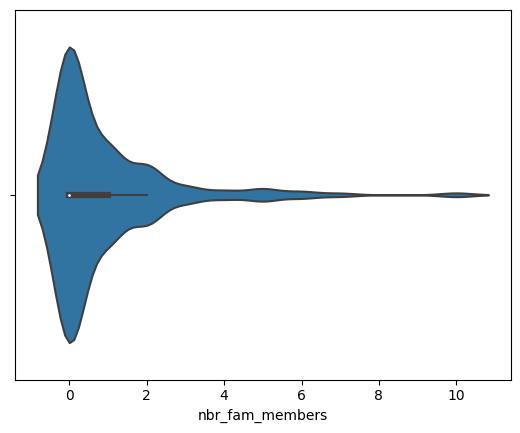

In [12]:
for quantitative in quantitative_vars:
    sns.violinplot(data=df, x=quantitative)
    plt.show()

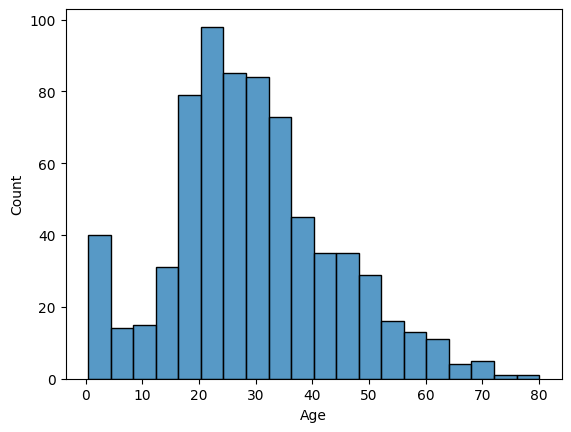

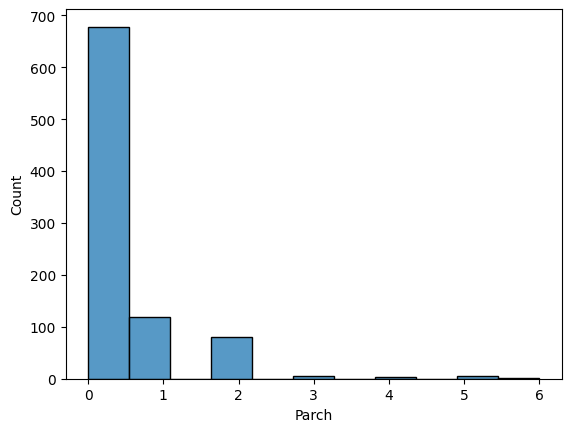

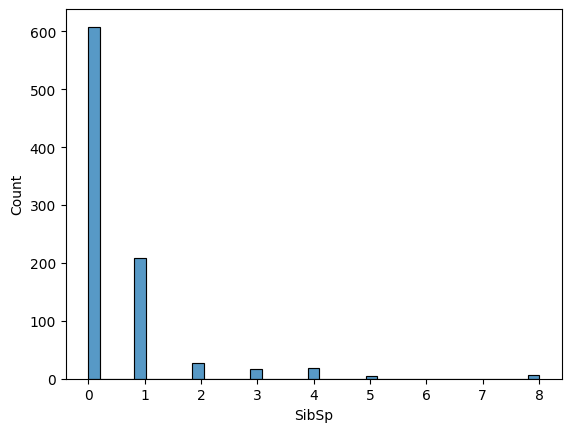

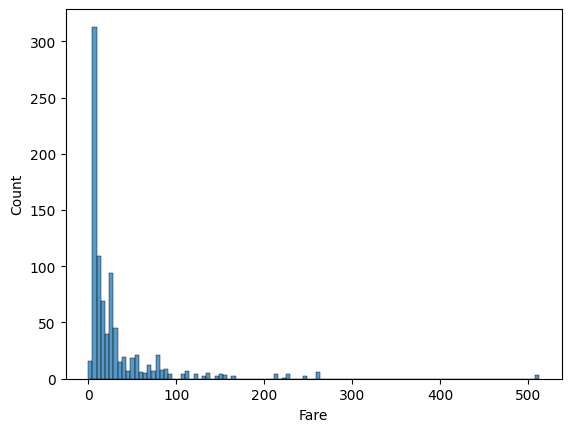

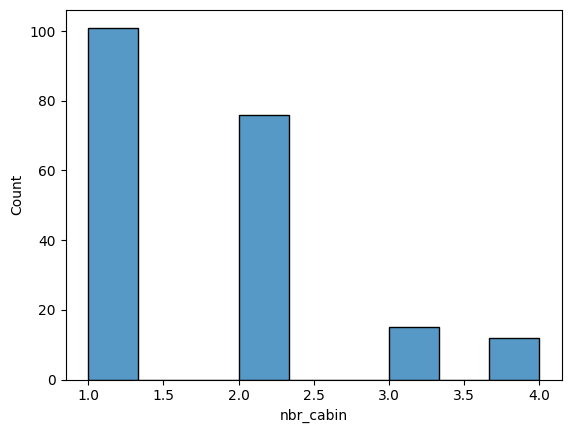

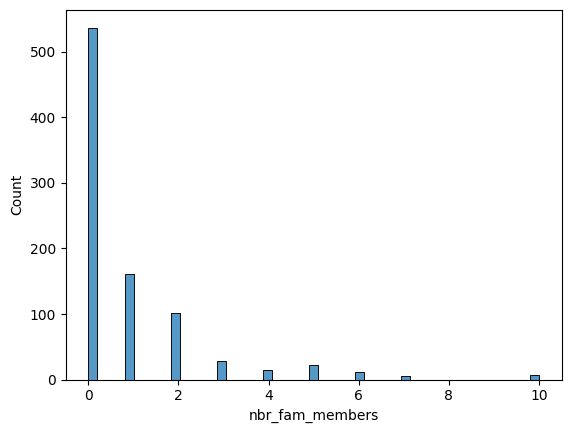

In [13]:
for quantitative in quantitative_vars:
    sns.histplot(data=df, x=quantitative)
    plt.show()

3. For each **qualitative variables** (that you should have stored in the variable `qualititative_vars`), provide the different values that can be taken by the variable and count the number of individuals per category.

In [14]:
df.value_counts

<bound method DataFrame.value_counts of      PassengerId  Survived Pclass  \
0              1         0      3   
1              2         1      1   
2              3         1      3   
3              4         1      1   
4              5         0      3   
..           ...       ...    ...   
886          887         0      2   
887          888         1      1   
888          889         0      3   
889          890         1      1   
890          891         0      3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                       

In [16]:
for qualitative in qualitative_vars:
    print(f"====== Repartition of variable {qualitative} ==========")
    print(df[qualitative].value_counts())

====== Repartition of variable Embarked ==========
S    644
C    168
Q     77
Name: Embarked, dtype: int64
====== Repartition of variable deck ==========
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: deck, dtype: int64
====== Repartition of variable with_family ==========
no     537
yes    354
Name: with_family, dtype: int64
====== Repartition of variable Sex ==========
male      577
female    314
Name: Sex, dtype: int64
====== Repartition of variable Pclass ==========
3    491
1    216
2    184
Name: Pclass, dtype: int64
====== Repartition of variable age_category ==========
adult     446
senior    241
minor     204
Name: age_category, dtype: int64
====== Repartition of variable cabin_shared ==========
n/a           687
shared        103
not_shared    101
Name: cabin_shared, dtype: int64


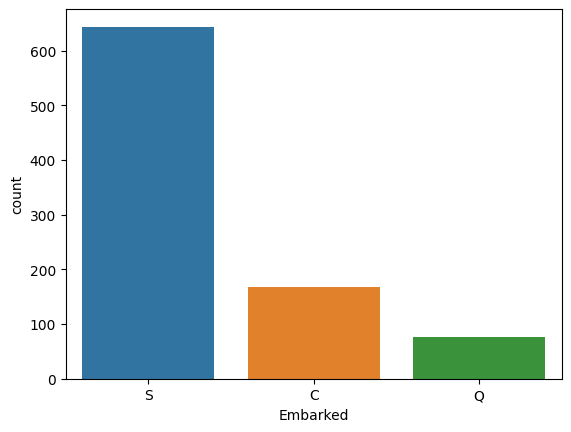

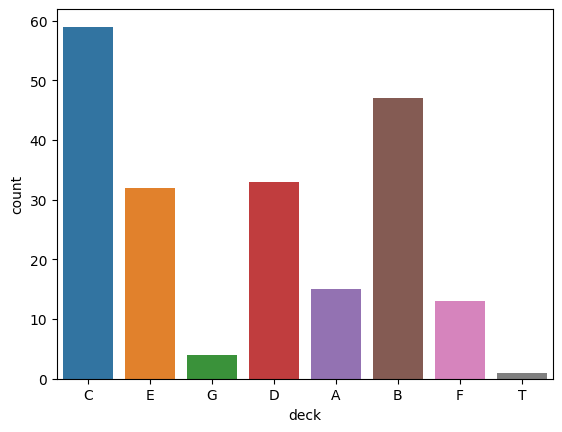

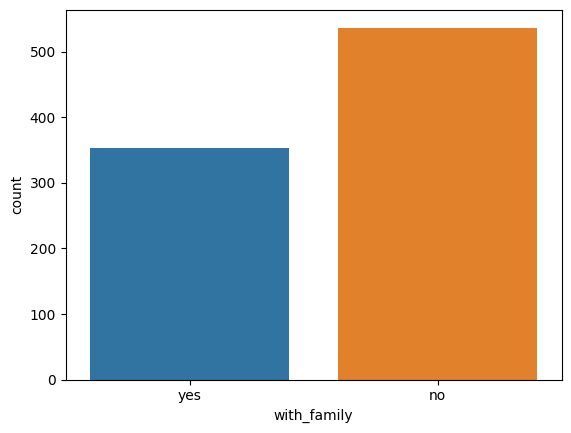

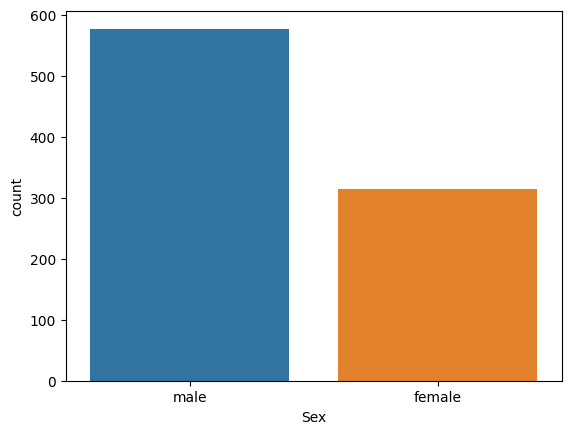

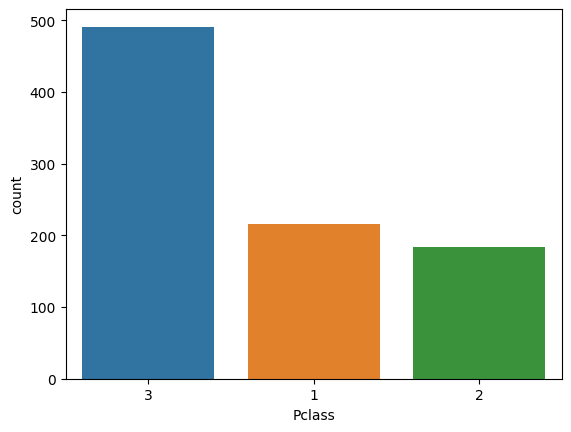

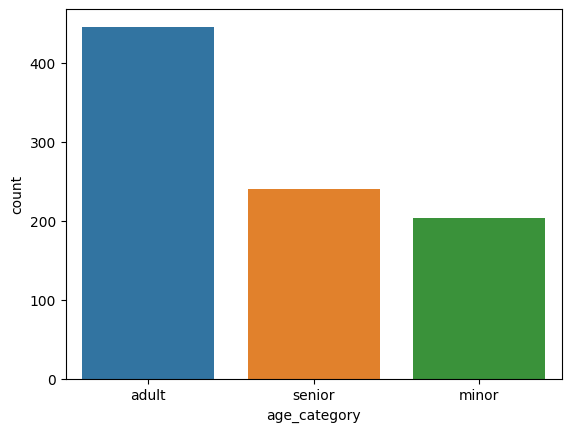

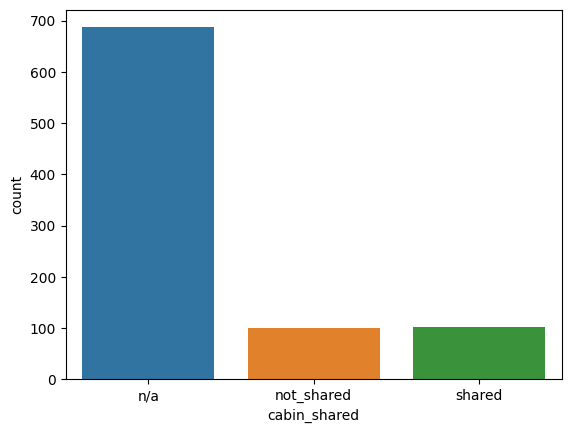

In [18]:
for qualitative in qualitative_vars:
    sns.countplot(data=df, x=qualitative)
    plt.show()

## Multivariate analysis

### Correlation of variables

1] Using the `.corr()` method, find and analyze correlations between features. What can you deduce regarding features independence ?

**Answer**: *Looking at the correlation matrix, we can see a strong correlation between some variables:*
- Correlation > 0.7: `nbr_fam_members` and ` Parch` which is expected given the definition of the two variables. Depending on how well they explain the survival data, we may drop one or the other.
* Correlation between 0.5 and 0.7: `nbr_fam_members` and `SibSp`, with the same justification as above. `nbr_cabin` as well as the others variables representing the family variables, which makes sense because families would share the same cabin.

In [19]:
df[quantitative_vars].corr()

,Age,Parch,SibSp,Fare,nbr_cabin,nbr_fam_members
Age,1.000000,-0.189119,-0.308247,0.096067,-0.366885,-0.301914
Parch,-0.189119,1.000000,0.414838,0.216225,0.439313,0.783111
SibSp,-0.308247,0.414838,1.000000,0.159651,0.383041,0.890712
Fare,0.096067,0.216225,0.159651,1.000000,0.132166,0.217138
nbr_cabin,-0.366885,0.439313,0.383041,0.132166,1.000000,0.518724
nbr_fam_members,-0.301914,0.783111,0.890712,0.217138,0.518724,1.000000


2] Plot the correlogram and perform a quick analysis of relationship between variables using `sns.pairplot`. Understand graph per graph what is represented and deduce from it the relationship between features and what feature seems to be important for prediction.

<Axes: >

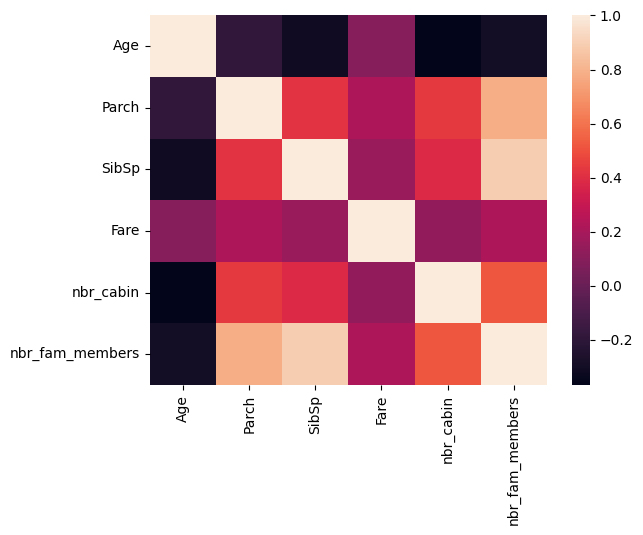

In [20]:
sns.heatmap(df[quantitative_vars].corr())

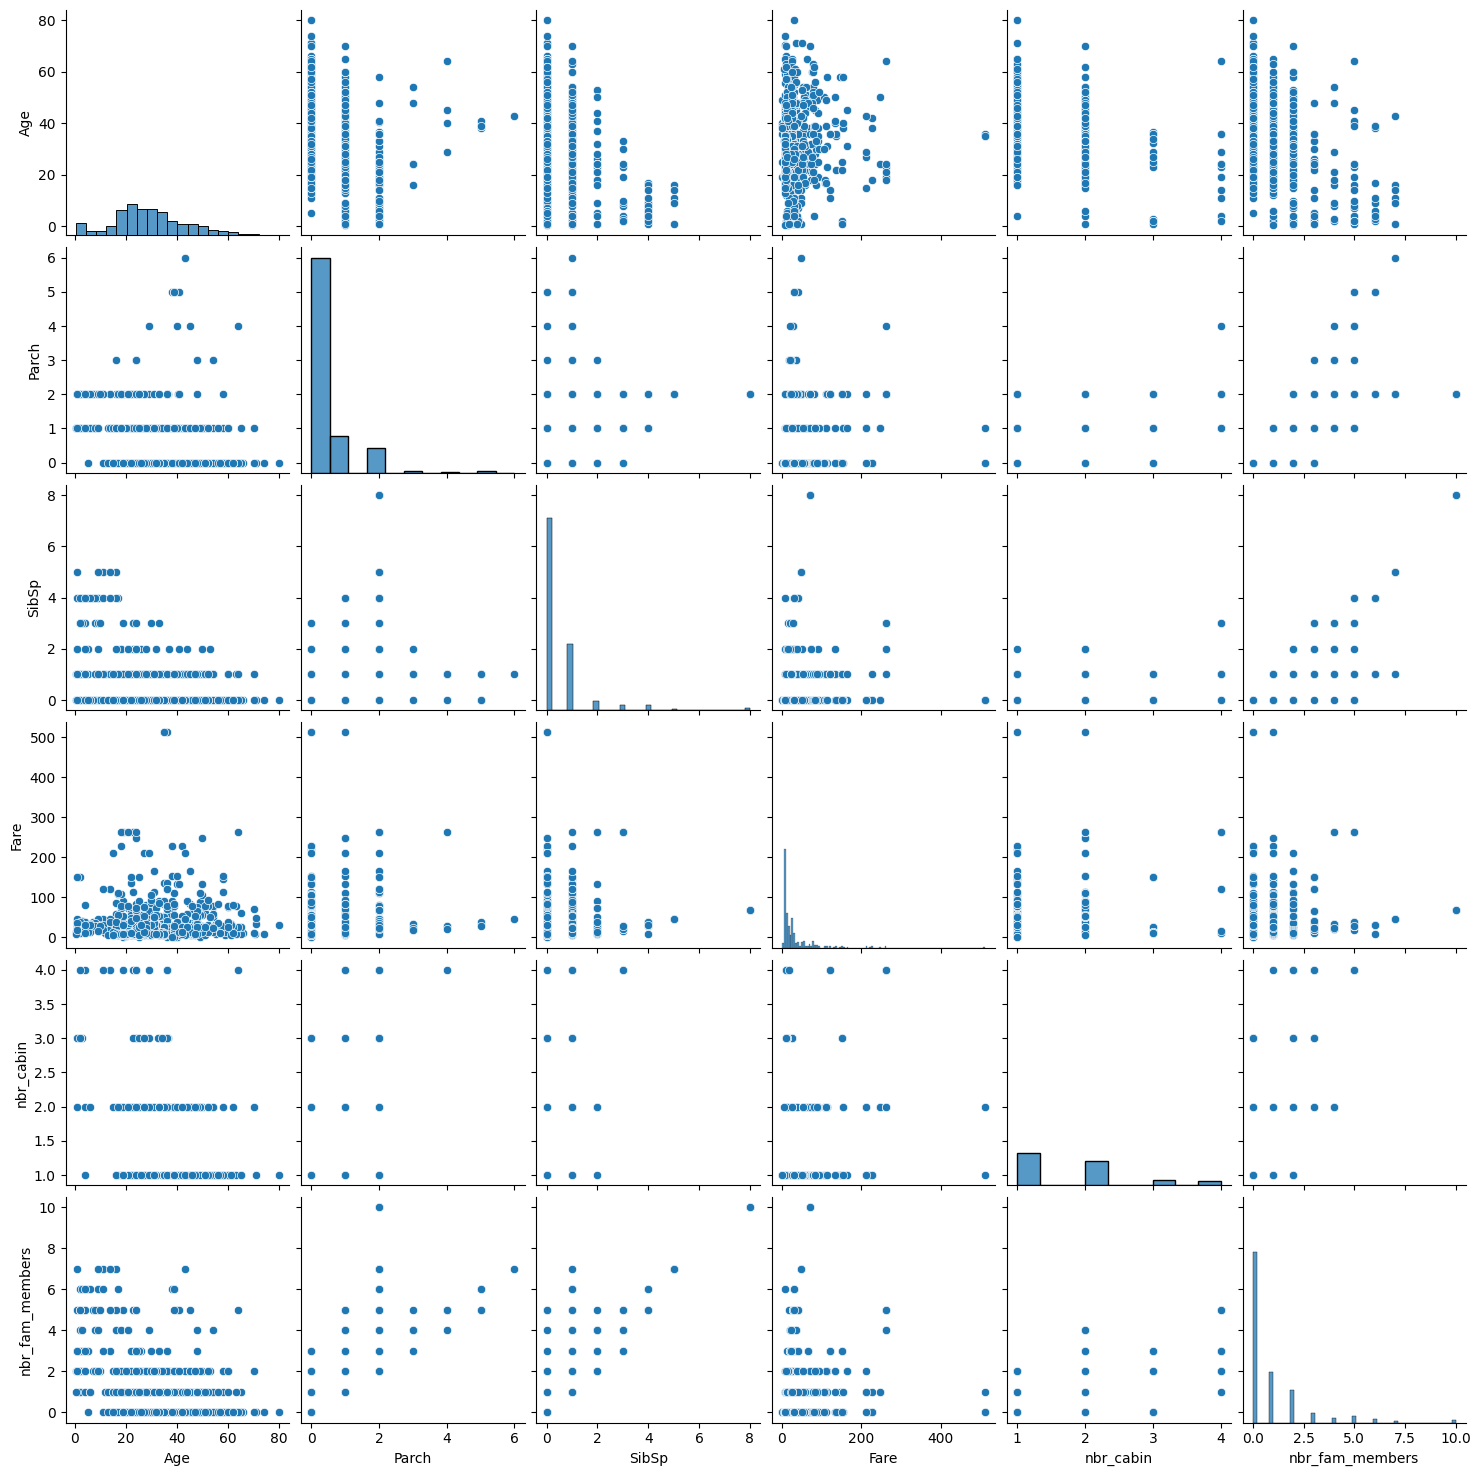

In [22]:
sns.pairplot(df[quantitative_vars])

### Impact of variables/features on target

The goal of our study is to **predict the target Survived**, so we need to analyze the relationship between this target and the features.

1] Find the statistical repartition of **quantitative variables** (that you should have stored in the variable `quantitative_vars`) for survivors and non-survivors and plot it using `sns.boxplot()`. 

**Answer (quick commentary that could be much longer)**:

- **Age**: Surprisingly (because one could expect that children would be more likely to be saved than adult), age seems to have little impact on the survival rate (around 28 years old for people who survived, 30 people across dead people). The age distribution seems similar as well, with a slight skewed distribution across the survived population: younger and older people seem to have survived (which would explain why we find a similar mean across populations).

- **Parch**: Most people didn't board with their children, making the distribution skewed towards 0. However, the means (.46 vs .33) tend to show that people with children have a higher survival rate.

- **SibSp**: SibSp shows the inverse trend, as having siblings does not seem to increase survival.

- **Fare**: Fare is highly skewed, but unsurprisingly, price discriminates survival: the higher the ticket was paid, the most likely its bearer was to survive. Individuals with very high fares have all survived. 

- **nbr_cabin**: In line with other variables measuring family, having a higher cabin occupation rate increases survival. It could also be due to the fact that sharing cabins would make escaping easier.

- **nbr_fam_members**: In line with other variables measuring family, having a higher number of family member increases survival.

Mean for Age across survived: 28.34
Mean for Age across death: 30.63


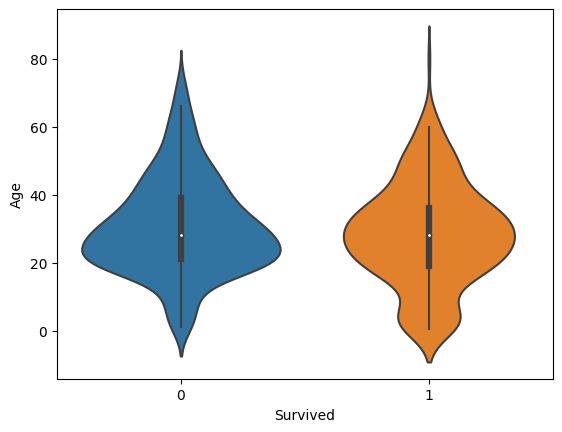

Mean for Parch across survived: 0.46
Mean for Parch across death: 0.33


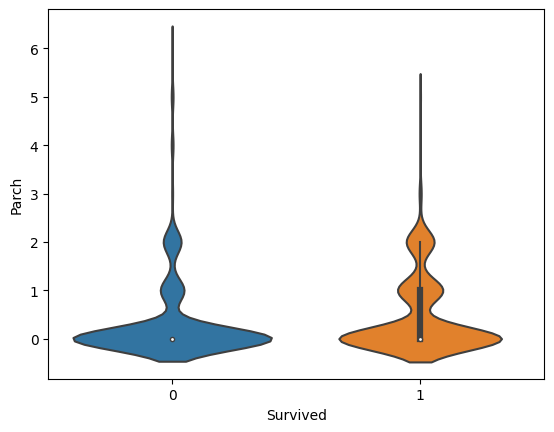

Mean for SibSp across survived: 0.47
Mean for SibSp across death: 0.55


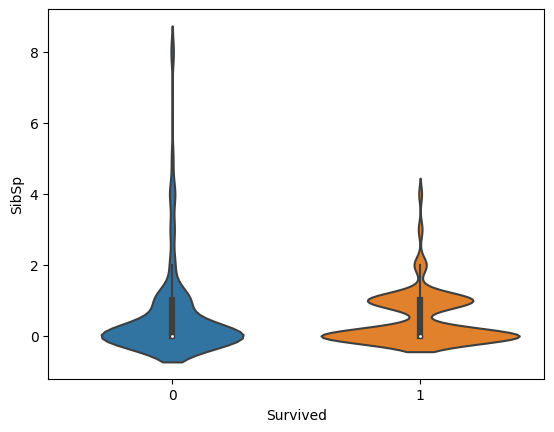

Mean for Fare across survived: 48.4
Mean for Fare across death: 22.12


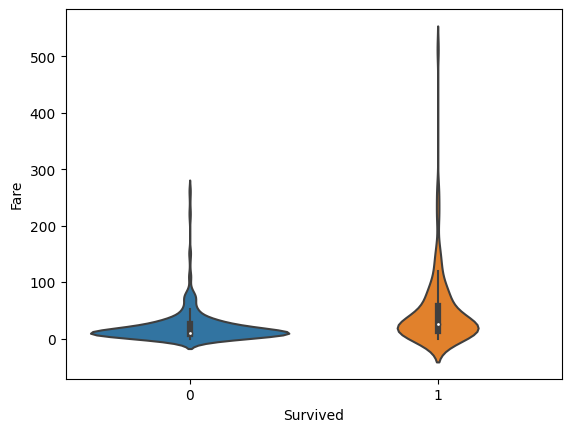

Mean for nbr_cabin across survived: 1.77
Mean for nbr_cabin across death: 1.54


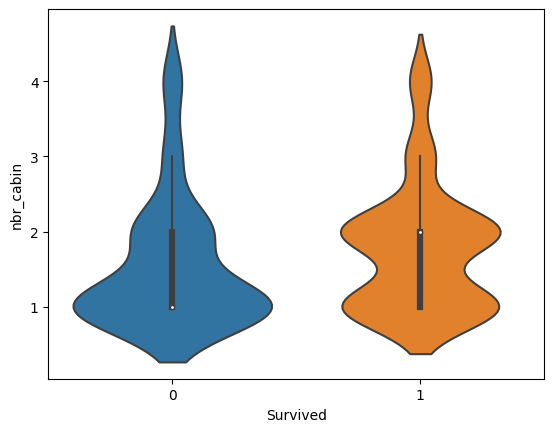

Mean for nbr_fam_members across survived: 0.94
Mean for nbr_fam_members across death: 0.88


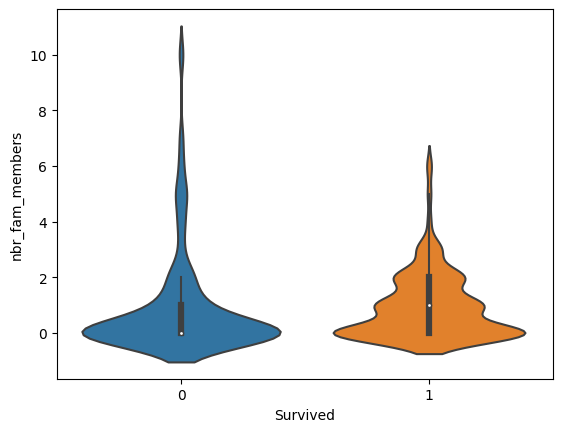

In [23]:
for quantitative in quantitative_vars:
    sns.violinplot(data=df, x="Survived", y=quantitative)
    print(f"Mean for {quantitative} across survived: {np.round(np.mean(df[df.Survived == 1][quantitative]), 2)}")
    print(f"Mean for {quantitative} across death: {np.round(np.mean(df[df.Survived == 0][quantitative]), 2)}")
    plt.show()
    

2] Find the statistical repartition of survivors for each **categorical variable** (that you should have stored in the variable `qualitative_vars`) and plot it using the `sns.barplot()` function.

**Answer (short comment on variables and their possible impact)**:
- `Embarked`: Embarked seems to have a strong impact on the survival rate: people boarding from Cherbourg were a lot more likely to survive, probably because of Cabin repartition.
- `Decks`: The embarked deck. This validates the relevance of creating the additional `deck` variable: deck E, D, B had a more survivors. Additional analysis, can you guess why from the Titanic plan ? https://www.encyclopedia-titanica.org/titanic-deckplans/
- `with_family`: Confirms our previous analysis and proves that having family members increases survival rate. This has to be cross-checked with the `sex` variable: could it be because women did not travel alone on the boat ?
- `Sex`: Women were a lot more likely to survive: approximately 74\% of women survived, making it one of the most discriminating variable.
- `Pclass`: As expected, the higher the class (correlated with the higher the Fare), the more likely people were to survive.
- `age_category`: The age category shows that minors and adults were most likely to survive: seniors were not more likely to survive.
- `cabin_shared`: As we discussed with quantitative variables, sharing a cabin improves survival rate.

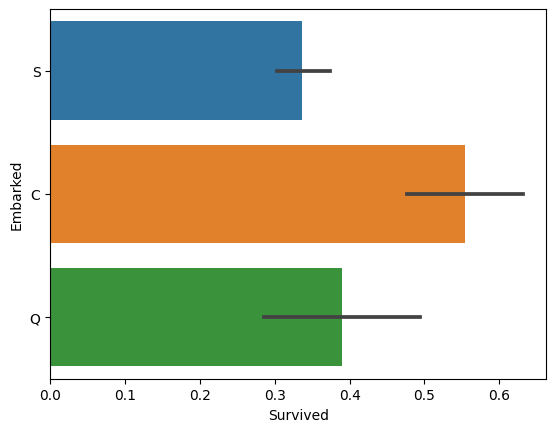

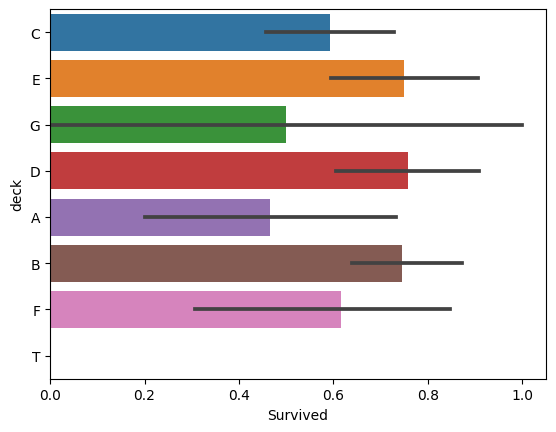

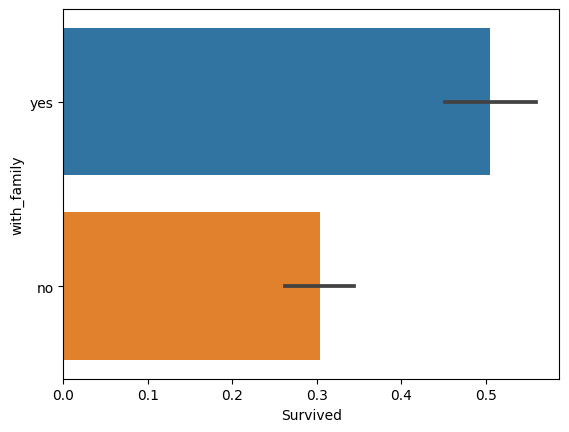

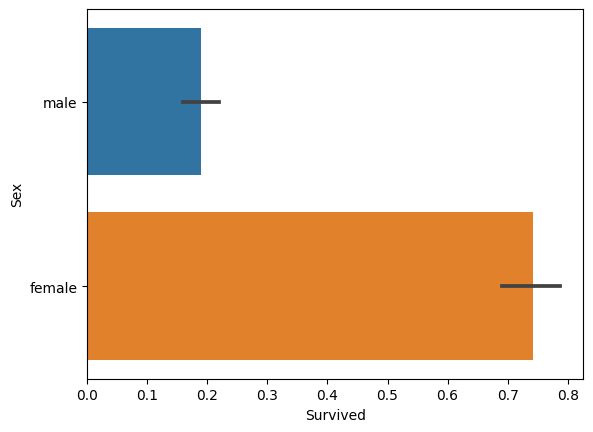

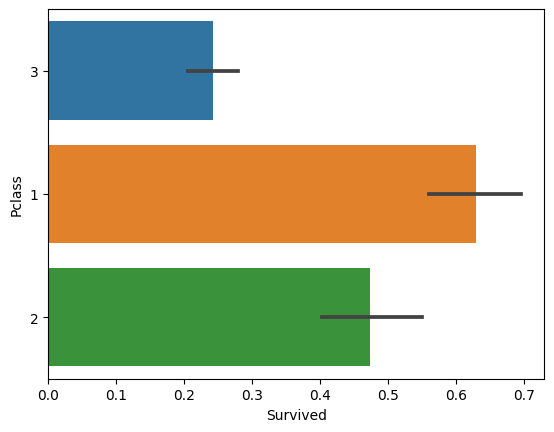

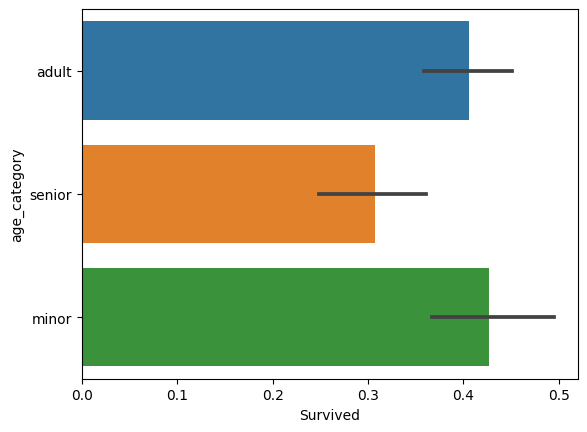

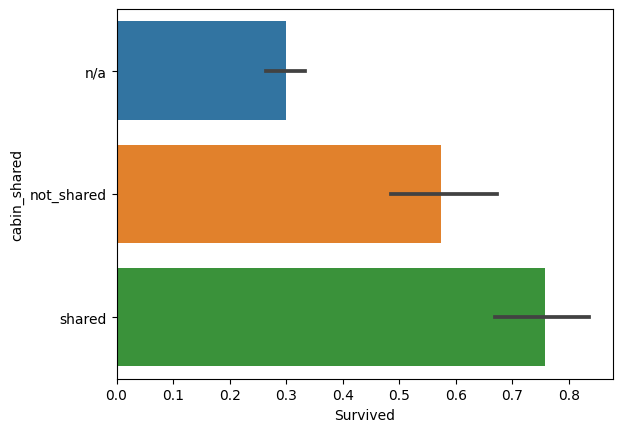

In [24]:
for qualitative in qualitative_vars:
    sns.barplot(data=df, x="Survived", y=qualitative)
    plt.show()

## Dealing with missing values

1. Have you noticed anything in particular with missing values ? 
**Answer**: *Some values are missing: individuals miss some values, which are replaced by N/A*.

2. Find rows with missing values using the `df.isna()` method and perform a statistical analysis on the number of missing values.

In [25]:
for variable in features:
    print(f"Number of passengers with missing {variable}: {df[df[variable].isna()].shape[0]}")

Number of passengers with missing Age: 177
Number of passengers with missing Parch: 0
Number of passengers with missing SibSp: 0
Number of passengers with missing Fare: 0
Number of passengers with missing nbr_cabin: 687
Number of passengers with missing nbr_fam_members: 0
Number of passengers with missing Embarked: 2
Number of passengers with missing deck: 687
Number of passengers with missing with_family: 0
Number of passengers with missing Sex: 0
Number of passengers with missing Pclass: 0
Number of passengers with missing age_category: 0
Number of passengers with missing cabin_shared: 0


3. Suggest possible ways to deal with missing values and apply it to the data.

For **quantitative variables**, we can set the missing values to the mean or to the median (median having the advantage of not skewing the distribution).

In [33]:
for variable in quantitative_vars:
    df[variable].fillna(df[variable].mean(), inplace=True)

For **qualitative variables**, we can set the missing values to a new category, for example "n/a". It will become a category on its own and will be treated as such. 

In [34]:
for variable in qualitative_vars:
    df[variable].fillna("n/a", inplace=True)

In [35]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lastname,nbr_fam_members,with_family,age_category,deck,nbr_cabin,cabin_shared
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,Braund,1,yes,adult,n/a,1.696078,n/a
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,Cumings,1,yes,adult,C,1.000000,not_shared
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,0,no,adult,n/a,1.696078,n/a
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,Futrelle,1,yes,adult,C,2.000000,shared
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,Allen,0,no,adult,n/a,1.696078,n/a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,Montvila,0,no,adult,n/a,1.696078,n/a
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,Graham,0,no,minor,B,1.000000,not_shared
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,Johnston,3,yes,senior,n/a,1.696078,n/a
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,Behr,0,no,adult,C,1.000000,not_shared


## Bonus: plot the categories for quantitative variables

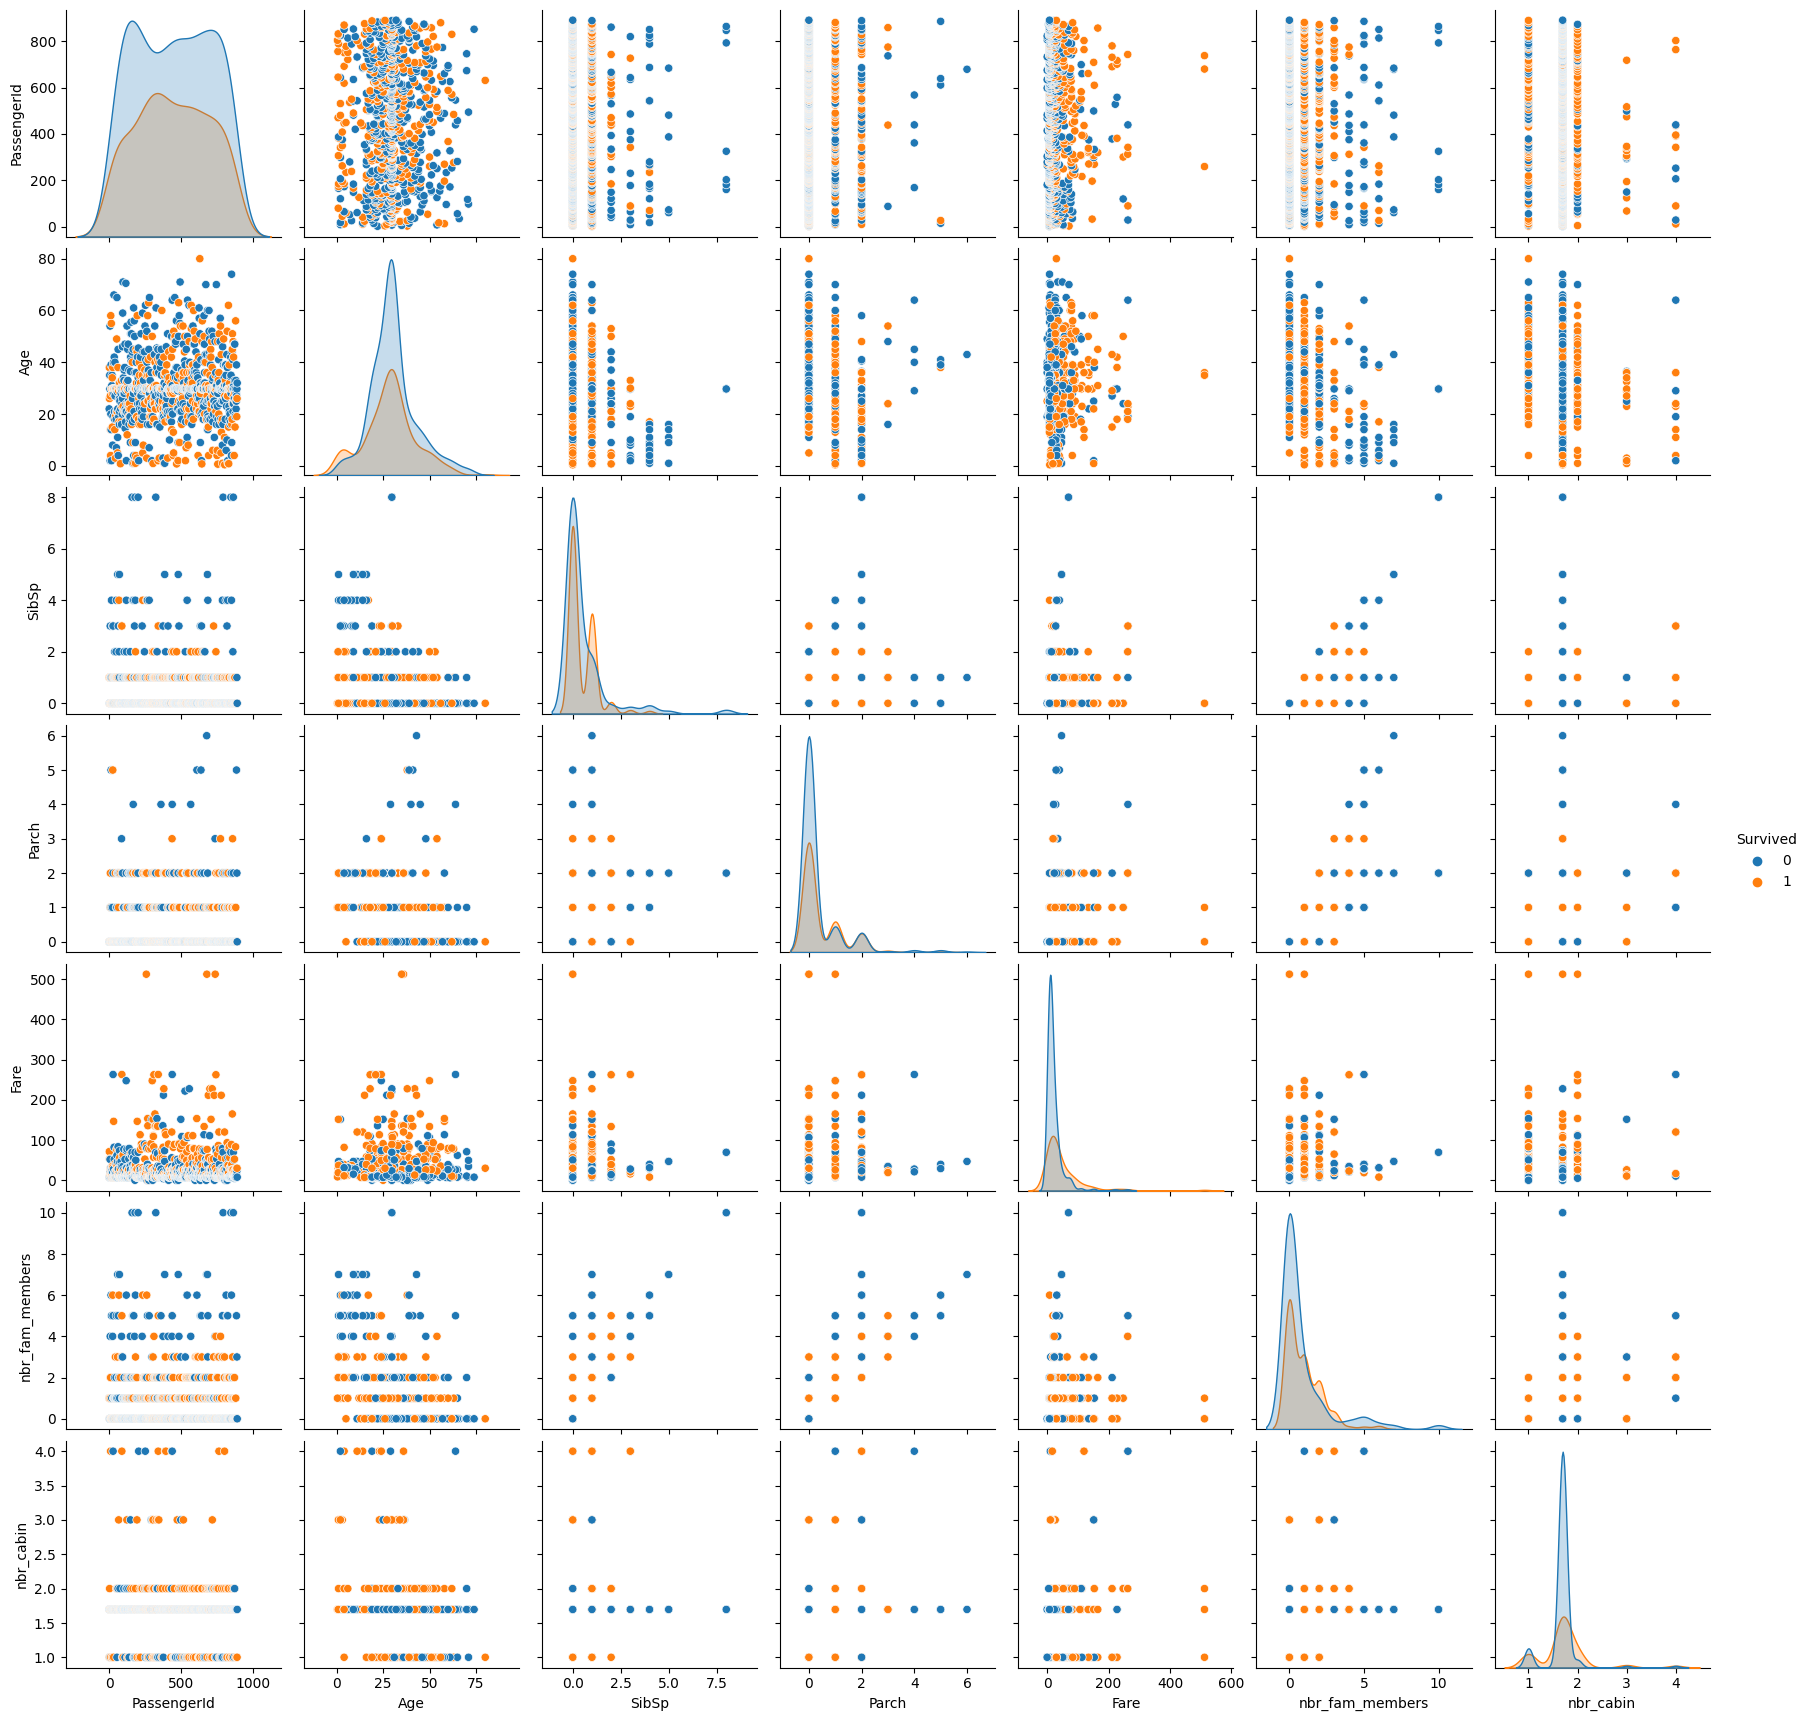

In [36]:
sns.pairplot(data=df, hue="Survived")

## Conclusions and next steps

1. What seems to be the most impacting features in the dataset to predict who survived ?
*Our study shows that the most impacting features are: whether or not the people embarked alone, the fare of the ticket, and whether or not the person was a woman.*


2. Do you think some metrics could be removed from the dataset without information loss ?
*It is difficult to answer categorically, but the following variables are highly correlated: `nbr_fam_members`, `SibSp`, `Parch`, `cabin_shared`, `nbr_cabin`. To check their influence, we will perform during the next steps the models with and without them.*


4. Store this new dataset into a csv file `titanic_pre_processed.csv` (using the `to_csv` method) and save it for the next lab.

In [ ]:
titanic_pre_processed = df[features].to_csv("titanic_pre_processed.csv")